## Classification Notes for Future Meeting (16/04/2024)
Notes for a future meeting - currently playing around with classification !

## Setup

In [30]:
import pathlib 

# data wrangle
import pandas as pd 
import numpy as np

# classify
from xgboost import XGBClassifier
from sklearn import metrics

# custom imports 
import sys
sys.path.append(str(pathlib.Path.cwd().parents[0]/ "src" / "classify"))
sys.path.append(str(pathlib.Path.cwd().parents[0]/ "src" / "utils"))
from prepare_data import load_metrics, filter_metrics
from classify import clf_pipeline, get_feature_importances, plot_feature_importances
from run_pca import plot_cumulative_variance, create_loadings, plot_loadings
from pca import run_PCA

# plots 
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
path = pathlib.Path.cwd()

## Pipeline of Prelim Feature Selection & Classification

### 0 Load & Filter Data: Stories (Temp 1)

In [22]:
datapath = path.parents[0] / "metrics"
dataset = "stories"

# load 
df = load_metrics(
                            human_dir=datapath / "human_metrics", 
                            ai_dir=datapath / "ai_metrics",
                            dataset=dataset, temp=1, 
                            human_completions_only=True, 
                            )

# filter
df = filter_metrics(df, percent_NA=0.9, percent_zero=0.9, verbose=True)

[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[INFO:] Dropped 13 rows based on doc length. Min tokens: 112, Max tokens: 1055
[INFO:] Min len in df: 112.0, Max len in df: 1014.0
[INFO:] Columns dropped: ['contains_lorem ipsum', 'duplicate_line_chr_fraction', 'duplicate_ngram_chr_fraction_10', 'duplicate_paragraph_chr_fraction', 'pos_prop_SYM', 'pos_prop_X', 'proportion_bullet_points', 'proportion_ellipsis', 'symbol_to_word_ratio_#', 'pos_prop_SPACE']


### 1 Feature Heatmaps

/tmp/ipykernel_21120/2692154755.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrM = df.drop(cols_to_drop, axis=1).corr()


Text(0.5, 1.0, 'Correlation Matrix: stories Temp1')

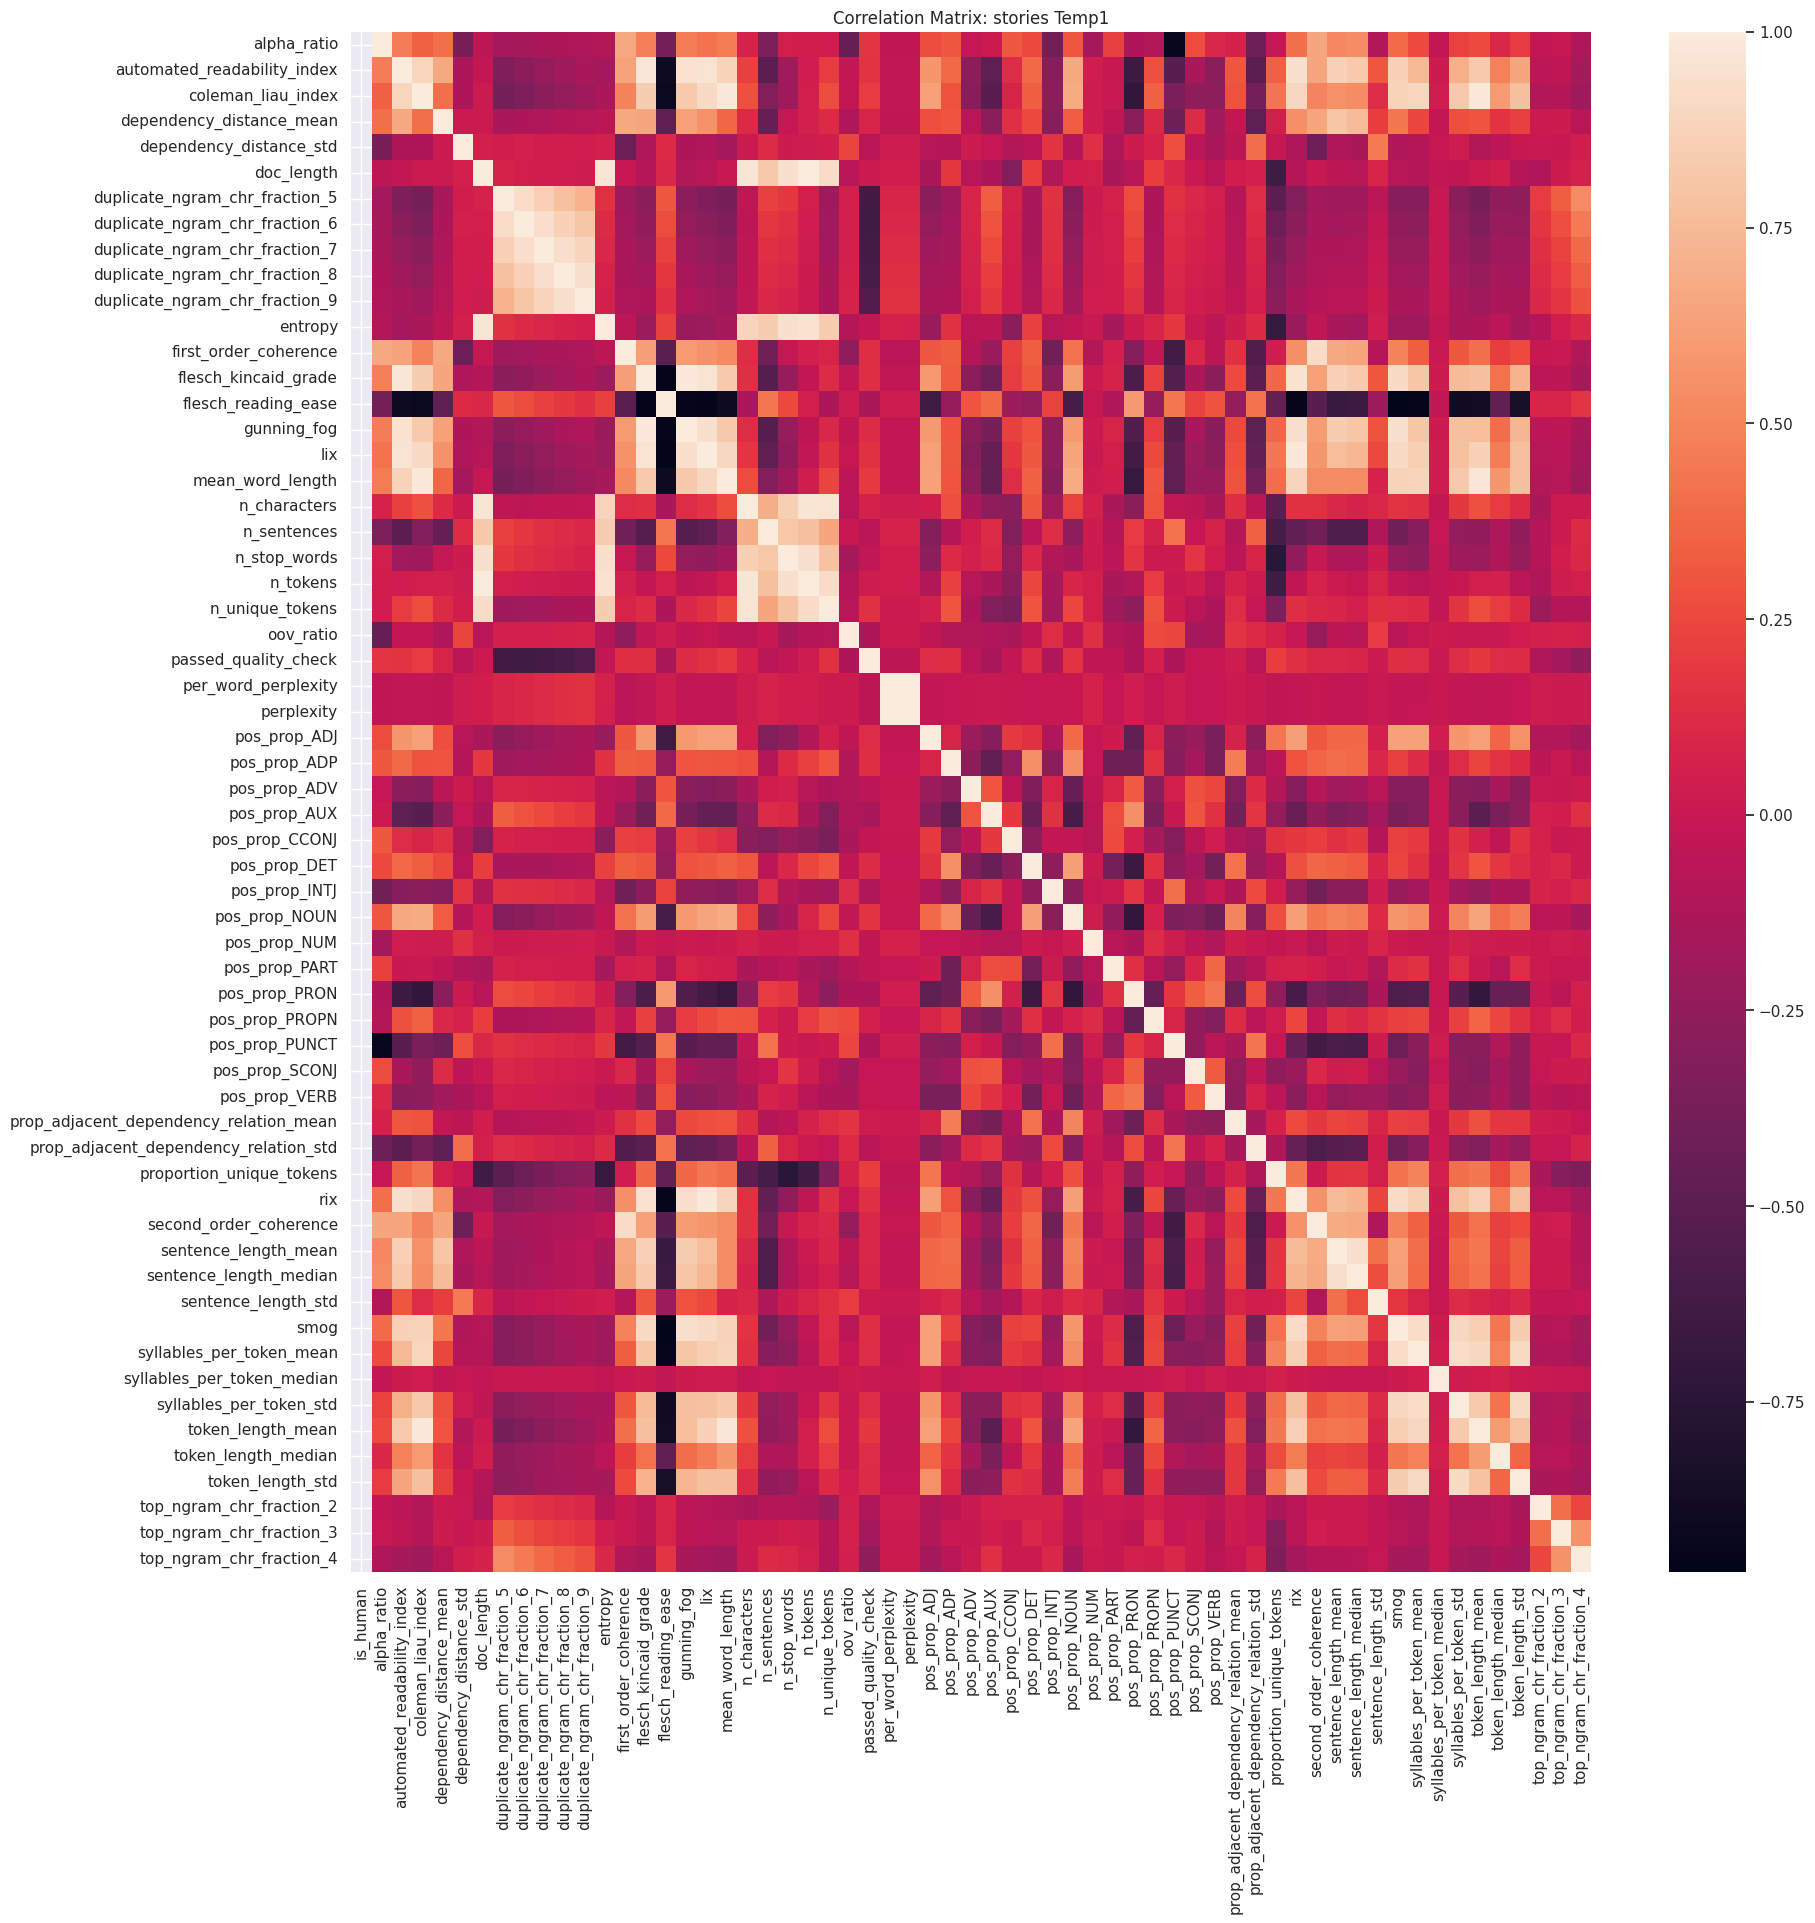

In [35]:
# define out irrelvant cols for correlation matrix
cols_to_drop = ["id", "unique_id", "sample_params", "temperature", "prompt_number"]

# create correlation matrix
corrM = df.drop(cols_to_drop, axis=1).corr()

# plot
sns.set_theme(rc={'figure.figsize':(20, 20)})

# drop na from corrM 
corrMplot = sns.heatmap(corrM.dropna(how="all"))
corrMplot.set_title(f"Correlation Matrix: {dataset} Temp1")

### 2 Classification & Feature Importances

[INFO:] Initializing XGClassifier ...
[INFO:] Creating splits with all features using random state 129 ...
[INFO:] Fitting classifier ...
[INFO:] Evaluating classifier ...


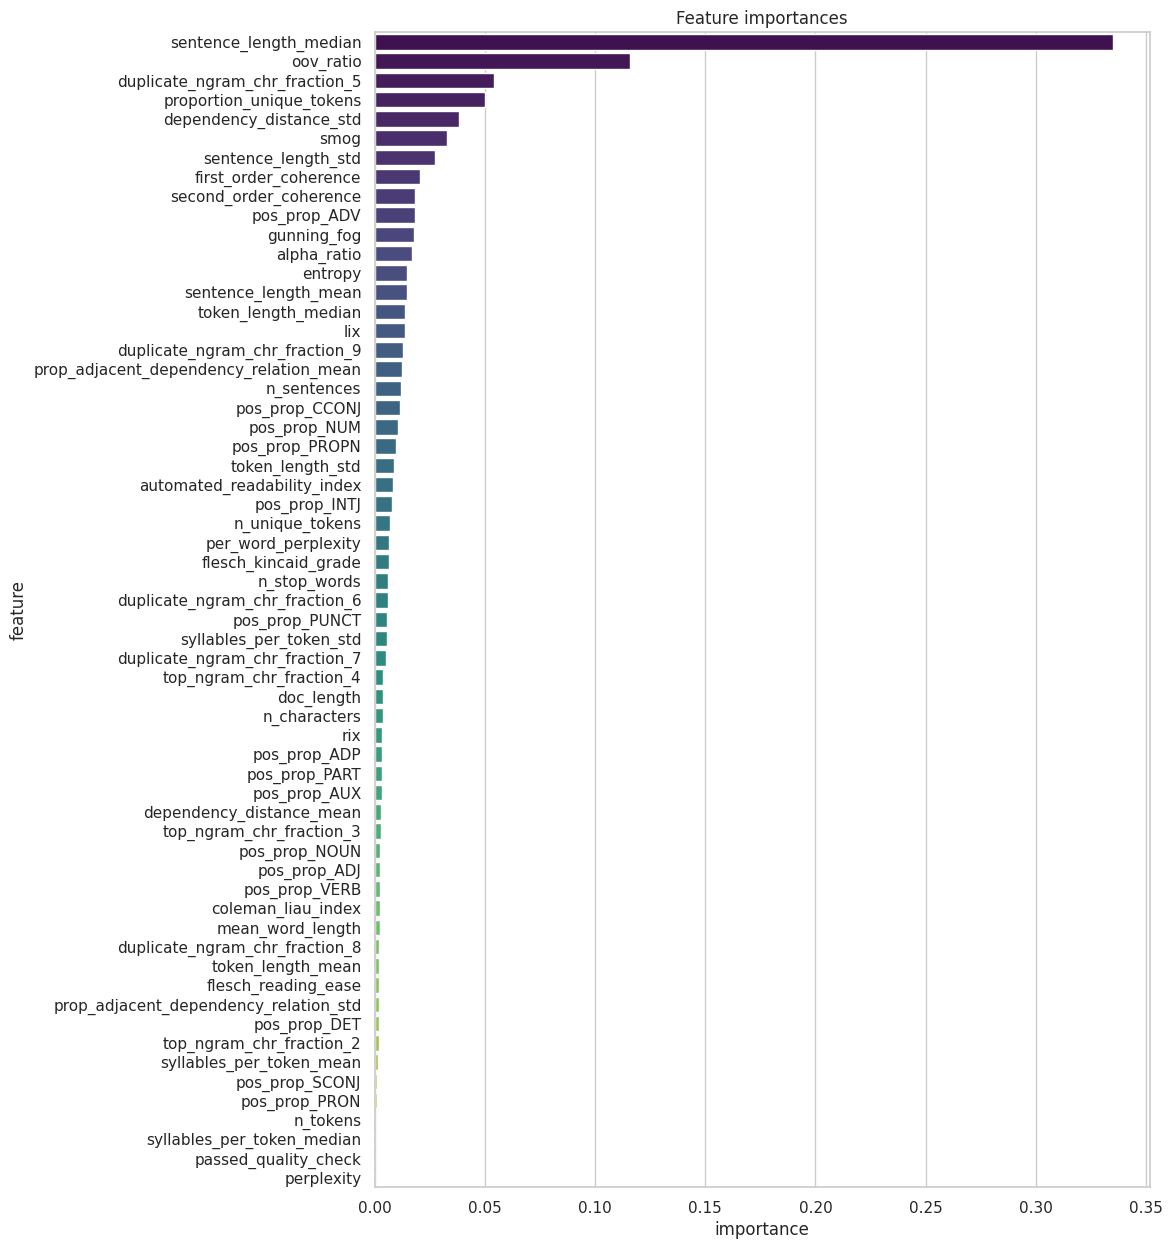

In [25]:
## ALL FEATURES ## 
# fit 
splits, clf, clf_report = clf_pipeline(df, random_state=129, features=None)

# feature importances
feature_importances = get_feature_importances(splits, clf)
plt.close()
plot_feature_importances(feature_importances)

[INFO:] Initializing XGClassifier ...
[INFO:] Creating splits with features: ['sentence_length_median', 'proportion_unique_tokens', 'oov_ratio'] using random state 129 ...
[INFO:] Fitting classifier ...
[INFO:] Evaluating classifier ...


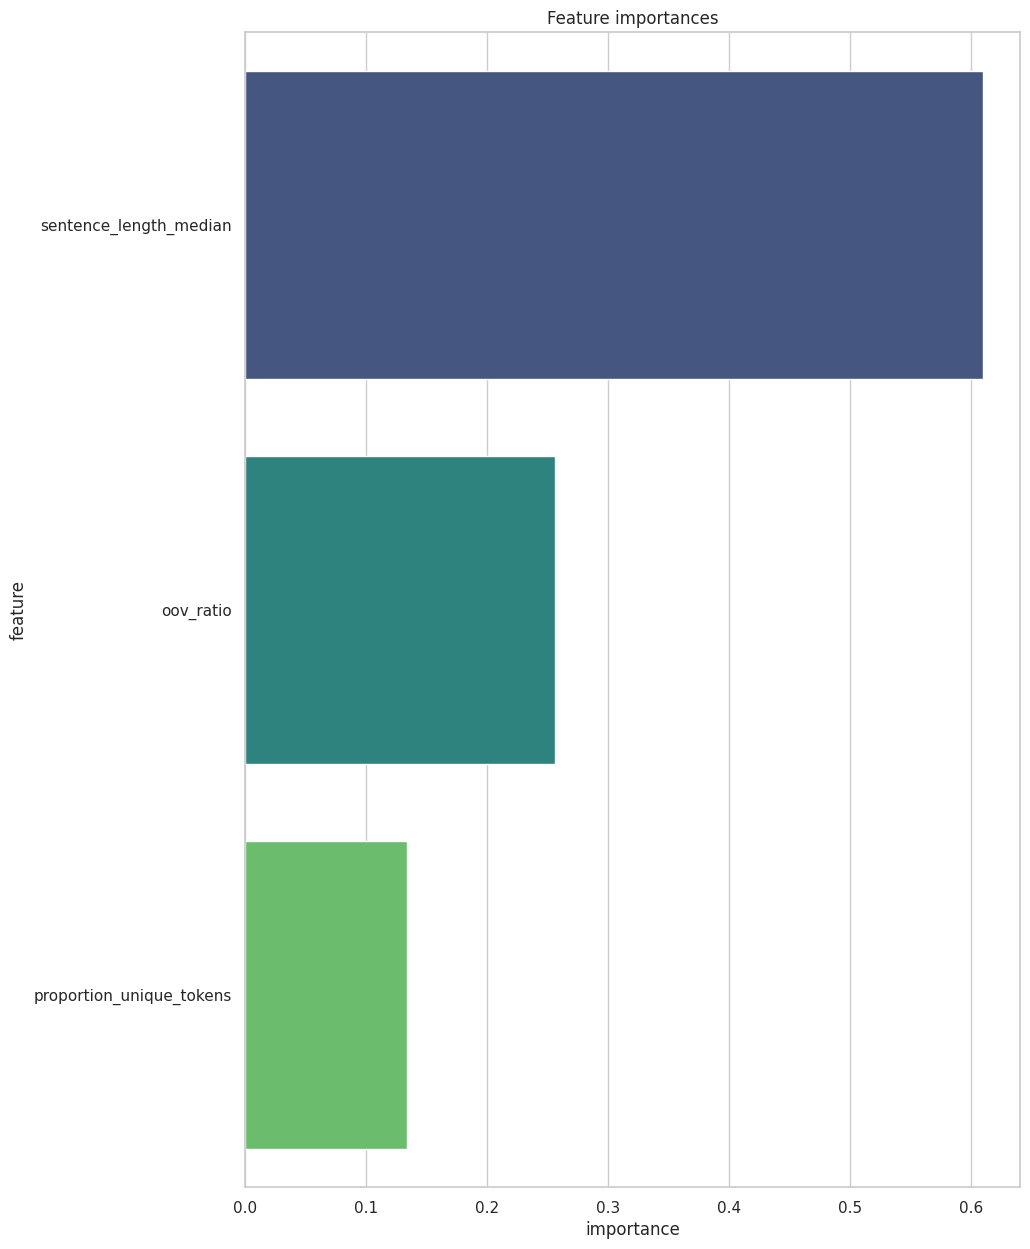

In [27]:
## SELECTED FEATURES
# define selected features
selected_features = ["sentence_length_median", "proportion_unique_tokens", "oov_ratio"]

# fit
splits, clf, clf_report = clf_pipeline(df, random_state=129, features=selected_features)

# feature importances
feature_importances = get_feature_importances(splits, clf)
plt.close()
plot_feature_importances(feature_importances) 

## 3 PCA: Dimensionality Reduction


## 4 Imbalanced Dataset? 

In [28]:
# define funtion to check imbalance from splits dict 
def check_imbalance(ai_dir, human_dir, temp=1):
    # create dict for saving imbalances
    imbalance = {}

    for dataset in ["stories", "mrpc", "dailydialog", "dailymail_cnn"]:
        df = load_metrics(human_dir=human_dir, ai_dir=ai_dir, dataset=dataset, temp=temp)
        splits = create_split(df, random_state=129, val_test_size=0.15, outcome_col="is_human", verbose=False)
        
        # dict with counts for each split
        imbalance[dataset] = {'train': splits['y_train'].value_counts(),
                              'val': splits['y_val'].value_counts(),
                              'test': splits['y_test'].value_counts()}
        
    # convert to df 
    imbalance_df = pd.DataFrame.from_dict({(dataset, split): imbalance[dataset][split] for dataset in imbalance.keys() for split in imbalance[dataset].keys()}, orient='index')
    imbalance_df.index.names = ['Dataset', 'Split']
    imbalance_df.reset_index(inplace=True)

    return imbalance_df

In [29]:
imbalance_df = check_imbalance(human_dir=datapath / "human_metrics", 
                            ai_dir=datapath / "ai_metrics")
print(imbalance_df) # where 0 is ai and 1 is human

[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
          Dataset  Split      0     1
0         stories  train  14000  3500
1         stories    val   3000   750
2         stories   test   3000   750
3            mrpc  train  10920  2730
4            mrpc    val   2340   585
5            mrpc   test   2340   585
6     dailydialog  train  14000  3500
7   

## Dimensionality Reduction

In [32]:
# get all possible features
all_features = df.columns.tolist() 

# define cols not to include in PCA
cols_to_not_include = ["model", "id", "is_human", "unique_id", "sample_params", "temperature", "prompt_number", "dataset"]

# remove cols not to include from all features
features = [feat for feat in all_features if feat not in cols_to_not_include]

 # drop all NA rows because PCA can't handle them
df = df.dropna()

# run PCA
pca, pca_df = run_PCA(df, feature_names=features, n_components=len(features))

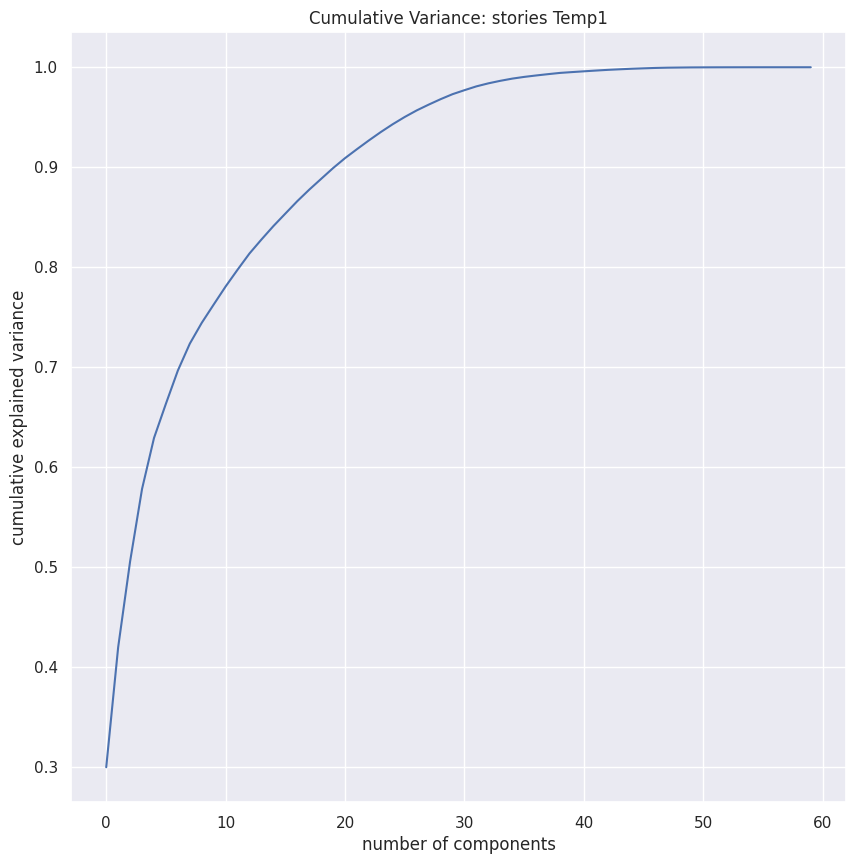

In [36]:
# plot cumulative variance
plot_cumulative_variance(pca, title = f"Cumulative Variance: {dataset} Temp1")

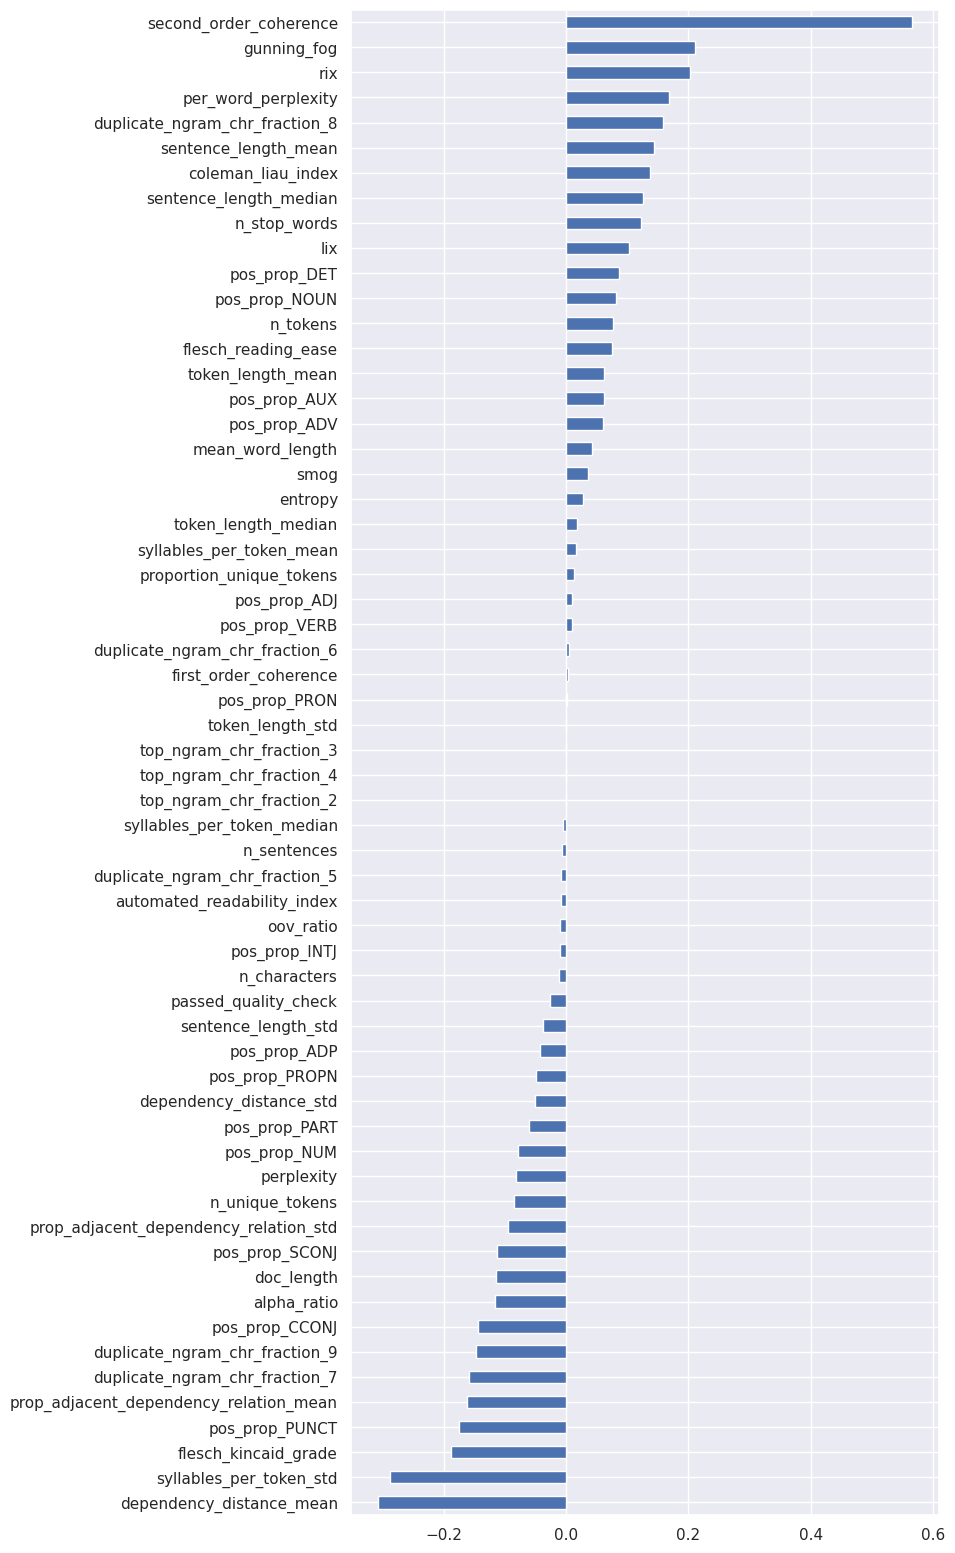

In [38]:
# create loadings
loadings = create_loadings(pca, features)

# get 3 most important features
plot_loadings(loadings, "PC1")

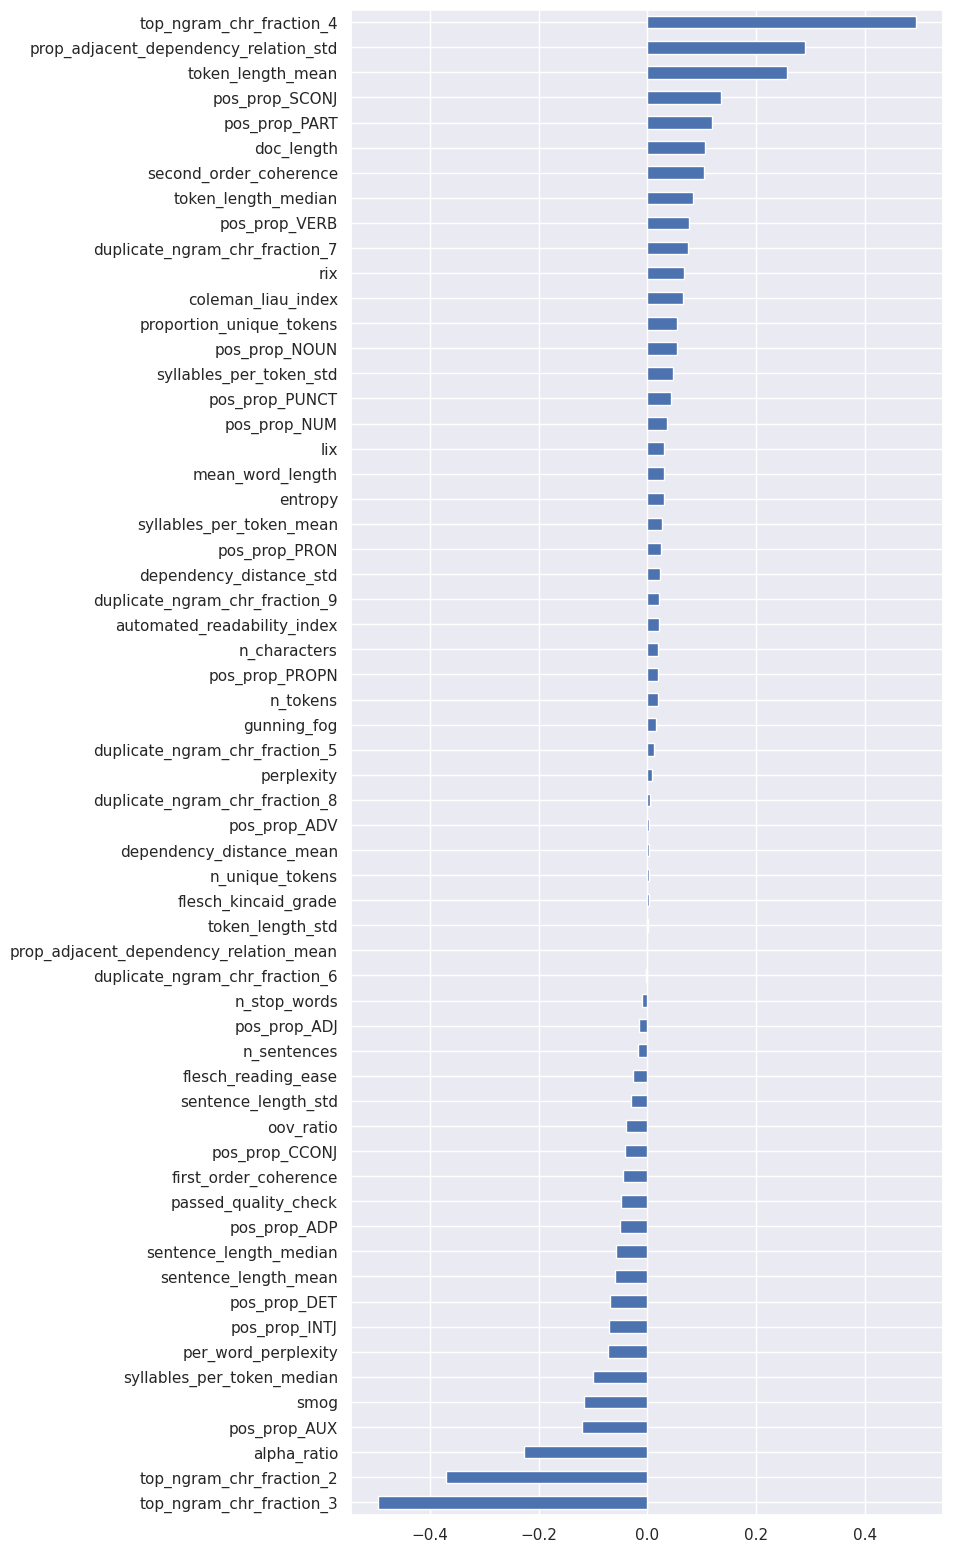

In [39]:
plot_loadings(loadings, "PC2")